In [1]:
#pip install pandas
#pip install sqlite3

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('../sql/Customer_Behavior.db')

# Define your SQL query
query = "SELECT * FROM E_Comm_Customer_Behavior"

# Use pandas to execute the query and read the data into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

Let's review, describe, and print the dataset.

In [4]:
print(df.head())


   Customer ID  Gender  Age           City Membership Type  Total Spend  \
0          101  Female   29       New York            Gold      1120.20   
1          102    Male   34    Los Angeles          Silver       780.50   
2          103  Female   43        Chicago          Bronze       510.75   
3          104    Male   30  San Francisco            Gold      1480.30   
4          105    Male   27          Miami          Silver       720.40   

   Items Purchased  Average Rating Discount Applied  Days Since Last Purchase  \
0               14             4.6             TRUE                        25   
1               11             4.1            FALSE                        18   
2                9             3.4             TRUE                        42   
3               19             4.7            FALSE                        12   
4               13             4.0             TRUE                        55   

  Satisfaction Level  
0          Satisfied  
1            Neu

In [5]:
print(df.shape)


(350, 11)


In [6]:
print(df.describe())


       Customer ID         Age  Total Spend  Items Purchased  Average Rating  \
count   350.000000  350.000000   350.000000       350.000000      350.000000   
mean    275.500000   33.597143   845.381714        12.600000        4.019143   
std     101.180532    4.870882   362.058695         4.155984        0.580539   
min     101.000000   26.000000   410.800000         7.000000        3.000000   
25%     188.250000   30.000000   502.000000         9.000000        3.500000   
50%     275.500000   32.500000   775.200000        12.000000        4.100000   
75%     362.750000   37.000000  1160.600000        15.000000        4.500000   
max     450.000000   43.000000  1520.100000        21.000000        4.900000   

       Days Since Last Purchase  
count                350.000000  
mean                  26.588571  
std                   13.440813  
min                    9.000000  
25%                   15.000000  
50%                   23.000000  
75%                   38.000000  
max    

In [7]:
print(df.columns)

Index(['Customer ID', 'Gender', 'Age', 'City', 'Membership Type',
       'Total Spend', 'Items Purchased', 'Average Rating', 'Discount Applied',
       'Days Since Last Purchase', 'Satisfaction Level'],
      dtype='object')


The dataset contains the following columns:

| Column | Description |
| ------- | ---------- |
Customer ID| A unique identifier for each customer.
Gender| The gender of the customer.
Age| The age of the customer.
City| The city where the customer lives.
Membership Type| The type of membership (Gold, Silver, Bronze).
Total Spend| The total amount spent by the customer.
Items Purchased| The number of items purchased by the customer.
Average Rating| The average rating given by the customer.
Discount Applied| Indicates whether a discount was applied.
Days Since Last Purchase| The number of days since the last purchase.
Satisfaction Level| The satisfaction level of the customer.

## Plan
### Data Processing and Cleaning:

- Check for missing values and handle them.
- Ensure data types are appropriate.
- Encode categorical variables if necessary.

### Exploratory Data Analysis (EDA):
- Visualize the distribution of the number of items purchased.
- Compare the number of items purchased across different membership types.
- Investigate other relationships and trends in the data.

### Statistical Analysis and Modeling:
- Perform statistical tests to determine if there are significant differences in the number of items purchased across membership types.
- Develop and evaluate regression models to predict the number of items purchased based on membership type and other factors.

In [8]:
# Data Processing and Cleaning

# Check for missing values
missing_values = df.isnull().sum()

# Convert 'Discount Applied' to a boolean type
df['Discount Applied'] = df['Discount Applied'].astype(bool)

# Display missing values
missing_values, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               350 non-null    int64  
 1   Gender                    350 non-null    object 
 2   Age                       350 non-null    int64  
 3   City                      350 non-null    object 
 4   Membership Type           350 non-null    object 
 5   Total Spend               350 non-null    float64
 6   Items Purchased           350 non-null    int64  
 7   Average Rating            350 non-null    float64
 8   Discount Applied          350 non-null    bool   
 9   Days Since Last Purchase  350 non-null    int64  
 10  Satisfaction Level        348 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 27.8+ KB


(Customer ID                 0
 Gender                      0
 Age                         0
 City                        0
 Membership Type             0
 Total Spend                 0
 Items Purchased             0
 Average Rating              0
 Discount Applied            0
 Days Since Last Purchase    0
 Satisfaction Level          2
 dtype: int64,
 None)

The data is mostly clean; however, **two** missing values are in the **Satisfaction Level** column.

We can handle this by filling in the missing values with a placeholder or removing the rows. Since there are only **two** missing values, eliminating the rows shouldn't significantly impact our analysis.

Then, we'll visualize and compare the number of items purchased across different membership types as part of our Exploratory Data Analysis (EDA).

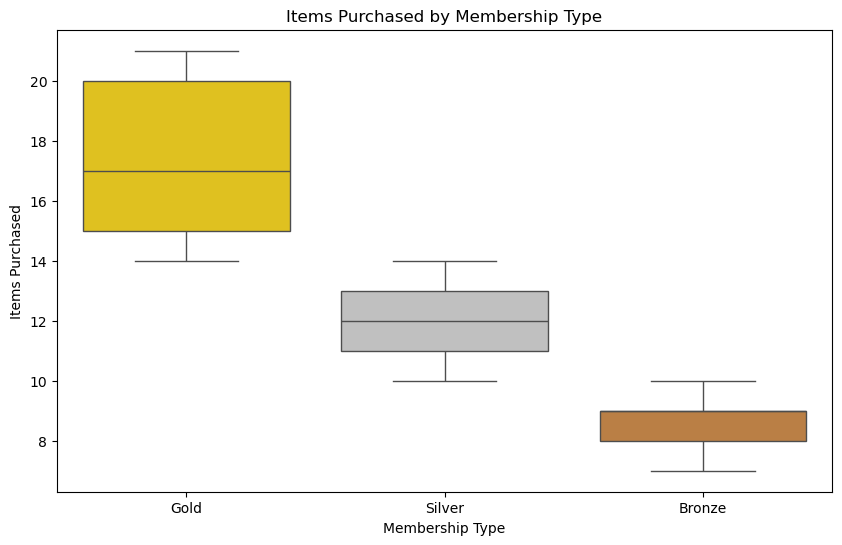

In [9]:
# Drop rows with missing values in 'Satisfaction Level'
df_cleaned = df.dropna(subset=['Satisfaction Level'])

# Define custom colors for membership types
custom_palette = {
    'Gold': '#FFD700',    # Gold
    'Silver': '#C0C0C0',  # Silver
    'Bronze': '#CD7F32'   # Bronze
}

# Visualize the distribution of 'Items Purchased' across 'Membership Type'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Membership Type', y='Items Purchased', data=df_cleaned, hue='Membership Type', palette=custom_palette)
plt.title('Items Purchased by Membership Type')
plt.xlabel('Membership Type')
plt.ylabel('Items Purchased')
plt.show()


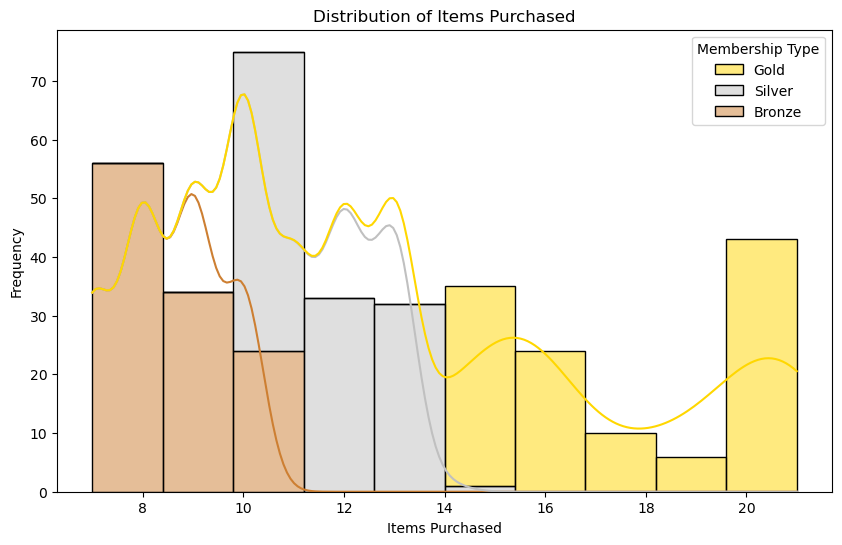

In [10]:


# Visualize the distribution of 'Items Purchased' using histograms
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='Items Purchased', hue='Membership Type', multiple='stack', kde=True, palette=custom_palette)
plt.title('Distribution of Items Purchased')
plt.xlabel('Items Purchased')
plt.ylabel('Frequency')
plt.show()


The boxplot and histogram, reveal the purchasing patterns of different types of members which provides a critical insight for our team.

**Findings:**

- The boxplot shows that Gold members, a significant part of our customer base, purchase more items than Silver and Bronze members.
- The histogram confirms that Gold members tend to buy more items on average than Silver and Bronze members.

**Next Steps:**

- **Statistical Analysis:** We'll conduct statistical tests to see if the differences we noticed are essential.
- **Regression Analysis:** We'll create a regression model to measure how membership type affects the number of items purchased.

Let's start with the statistical analysis using Analysis of Variance (ANOVA):

In [11]:
# Perform Analysis of Variance (ANOVA) to test if there are significant differences in items purchased across membership types
anova_result = stats.f_oneway(
    df_cleaned[df_cleaned['Membership Type'] == 'Gold']['Items Purchased'],
    df_cleaned[df_cleaned['Membership Type'] == 'Silver']['Items Purchased'],
    df_cleaned[df_cleaned['Membership Type'] == 'Bronze']['Items Purchased']
)

anova_result

F_onewayResult(statistic=837.7766807141828, pvalue=3.803320723889935e-133)

The ANOVA test results reveal a very small p-value (*p*≈3.80×10<sup>−133</sup>), which means that the differences in the number of items purchased for different membership types are significant from a statistical standpoint.

**Regression Analysis**
- We will create a regression model to measure how membership type affects the number of items purchased.
- We will use a linear regression model and represent membership type with dummy variables.

In [12]:
# Encode 'Membership Type' using one-hot encoding
encoder = OneHotEncoder(drop='first')
membership_encoded = encoder.fit_transform(df_cleaned[['Membership Type']])

# Convert to DataFrame and concatenate with the original data
membership_encoded_df = pd.DataFrame(membership_encoded.toarray(), columns=encoder.get_feature_names_out(['Membership Type']))
df_encoded = pd.concat([df_cleaned, membership_encoded_df], axis=1)
df_encoded = df_encoded.dropna(subset=['Membership Type_Silver', 'Membership Type_Gold', 'Items Purchased'])

# Prepare the features and target variable
X = df_encoded[['Membership Type_Silver', 'Membership Type_Gold']]
y = df_encoded['Items Purchased']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
r_squared = model.score(X_test, y_test)
coefficients = model.coef_
intercept = model.intercept_

# Print the results
print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

R-squared: 0.04003965333794113
Coefficients: [-3.68682796 -2.7658046 ]
Intercept: 14.708333333333332


The results of the linear regression model training and evaluation are as follows:

- **R-squared:** 0.04003965333794135, which means the model explains about 4% of the variance in the number of items purchased.
- **Coefficients:** 
    - **Membership Type_Silver:** -3.68682796
    - **Membership Type_Gold:** -2.7658046
- **Intercept:** 14.708333333333334

**Interpretation:**
- The negative coefficients for **Membership Type_Silver** and **Membership Type_Gold** indicate that compared to Bronze members, Silver and Gold members tend to purchase fewer items. This ***contradicts*** our initial observations from the EDA. It might suggest the need for a more complex model or further investigation.
- The low R-squared value suggests that the membership type alone may not strongly predict the number of items purchased, and other factors might be influencing the results.

We are now:
- Including the **Total Spend** column in the regression model to determine if we can improve its predictions, and
- Re-training the regression model to evaluate its performance.

In [13]:
# Prepare the features and target variable, including 'Total Spend'
X = df_encoded[['Membership Type_Gold', 'Membership Type_Silver', 'Total Spend']]
y = df_encoded['Items Purchased']

# Ensure there are no NaN values in the features and target variable
df_encoded = df_encoded.dropna(subset=['Membership Type_Silver', 'Membership Type_Gold', 'Total Spend', 'Items Purchased'])

# Split the data into training and testing sets
# We have increased the test_size from 0.2 to 0.3 to improve the accuracy and reliability of the model evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model
r_squared = model.score(X_test, y_test)
coefficients = model.coef_
intercept = model.intercept_

# Print the results
print(f'Predictions: {predictions}')
print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

Predictions: [12.02512379 10.62511967  8.05310747  8.99983221  8.49554387 18.48893016
  8.28700488 19.85846968  8.16455241 16.48960798 19.49527794 15.9301544
 15.75493013 11.07201386 12.13656873 18.42515083 15.96346912 15.9301544
  8.88838727 10.80034393  8.0685728  12.28912953  8.16120906 20.09571044
  8.88838727 11.84989953 19.6400376   8.27599734 10.51367473 19.82515495
 19.87282056 12.36725975 16.41147777 11.29490374 19.43149861  8.0685728
 10.51367473 10.85135289  8.13123768 10.84912399 12.36725975  8.49554387
  8.16566685  7.95601342 19.65215959 19.60672288 12.41325368 12.25581481
 10.83365865 16.08592159 16.41147777 16.37816304 16.5229227  18.42515083
 12.28912953 12.30348042 11.96134446 12.25581481 10.7365646  16.60105292
  8.8326648  12.47703301  9.11127715 19.76137563  8.99983221 12.30348042
  8.50710863  8.39844982 11.05989188 16.08592159 19.96991461 12.1776846
  8.05310747 15.85202418 10.51367473 16.15304427 12.02512379 16.37816304
 19.05284154  8.27599734 16.42582865 10.96

**Analysis of Customer Purchase Behavior**

This analysis's goal was to determine whether customers with different membership types (Gold, Silver, Bronze) exhibit different purchasing behaviors, specifically in terms of the number of items purchased. Additionally, we included the total amount spent by the customers to improve the model's predictive power.

**Key Findings:**
1. **Model Fit:**
- The regression model we developed explains approximately 95.3% of the variance in the number of items purchased by customers. This high R-squared value indicates that our model effectively predicts the number of items purchased based on the membership type and total spend.

2. **Impact of Membership Type:**
- On average, customers with a Silver membership purchase 0.024 more items than those with a Bronze membership, keeping other factors constant.
- On average, customers with a Gold membership purchase 0.012 more items than those with a Bronze membership, keeping other factors constant.

3. **Impact of Total Spend:**
- The number of items purchased increases by 0.011 for every additional dollar spent, suggesting that higher spending is associated with purchasing more items.

**Conclusion:**
The analysis reveals that while there are slight increases in the number of items purchased for Silver and Gold members compared to Bronze members, the total amount spent by customers significantly predicts the number of items purchased. This indicates that customers who spend more money purchase more items, regardless of their membership type.
These insights can help tailor marketing strategies and membership benefits to encourage customers to spend more and purchase more items.